In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import rfpimp
from yellowbrick.classifier import ROCAUC

from utils import get_project_root
import utils
from data_statistical_features import Segment
from ml_statistical_features import load_data_as_dataframe
from eda_utils import get_correlated_columns

plt.rcParams.update(utils.get_plt_settings())

save=True

/Users/zianor/.virtualenvs/venv/Bachelorarbeit/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


# Load Data

In [7]:
df = load_data_as_dataframe(segment_length=10, overlap_amount=0, hr_threshold=10)

df.rename(columns={'number_zero_crossings': 'number zero crossings', 'mean_signal_envelope' : 'mean signal envelope',
                  'variance_local_minima' : 'variance local minima', 'variance_local_maxima' : 'variance local maxima', 
                  'mean_signal_envelope': 'mean signal envelope'}, inplace=True)

features = df.drop(['brueser_sqi', 'patient_id', 'informative', 'ecg_hr', 'bcg_hr', 'abs_err', 'rel_err', 'quality_class', 'error'], axis='columns')
target = df['informative']
error = df['error']
bcg_hr = df['bcg_hr']
ecg_hr = df['ecg_hr']
patient_id = df['patient_id']

In [8]:
from ml_statistical_features import get_patient_split
x_train, x_test, y_train, y_test, groups_train, groups_test = get_patient_split(features, target, patient_id, test_size=0.33)

# Features reduzieren

In [6]:
get_correlated_columns(features.loc[x_train.index], 0.95)

['maximum',
 'std',
 'range',
 'mad',
 'variance local minima',
 'mean signal envelope']

In [7]:
fdm = rfpimp.feature_dependence_matrix(x_train)

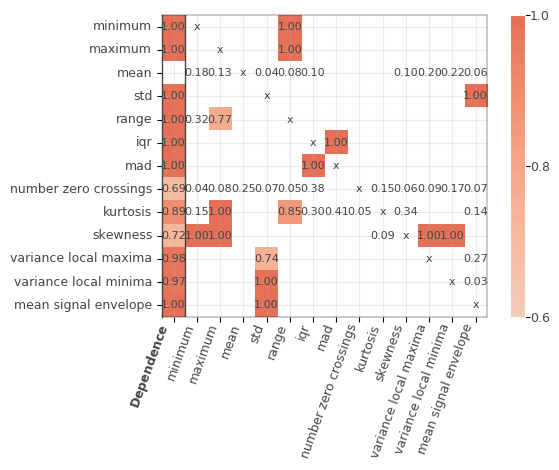

In [8]:
plt.rcParams.update(plt.rcParamsDefault)
rfpimp.plot_dependence_heatmap(fdm, value_fontsize=8, label_fontsize=9)
plt.rcParams.update(utils.get_plt_settings())

In [9]:
fdm_reduced = rfpimp.feature_dependence_matrix(x_train.drop(['maximum', 'minimum', 'mad', 'mean signal envelope',
                                                             'variance local minima', 'variance local maxima'],
                                                            axis='columns'))

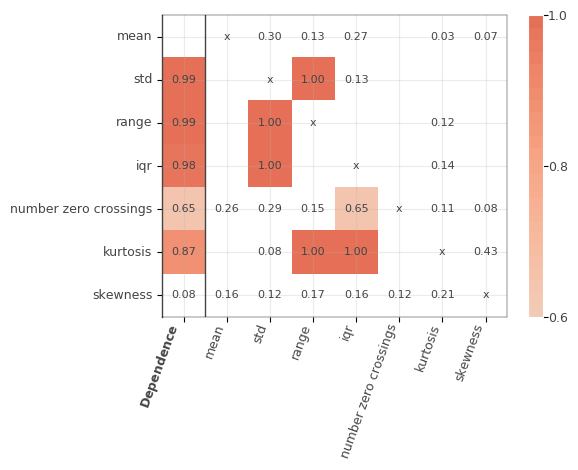

In [12]:
plt.rcParams.update(plt.rcParamsDefault)
rfpimp.plot_dependence_heatmap(fdm_reduced, value_fontsize=8, label_fontsize=9)
plt.rcParams.update(utils.get_plt_settings())

In [39]:
fdm_reduced_further = rfpimp.feature_dependence_matrix(x_train.drop(['maximum', 'minimum', 'mean signal envelope', 'mad'
                                                                     'variance local minima', 'variance local maxima',
                                                                     'iqr', 'range'], axis='columns'))

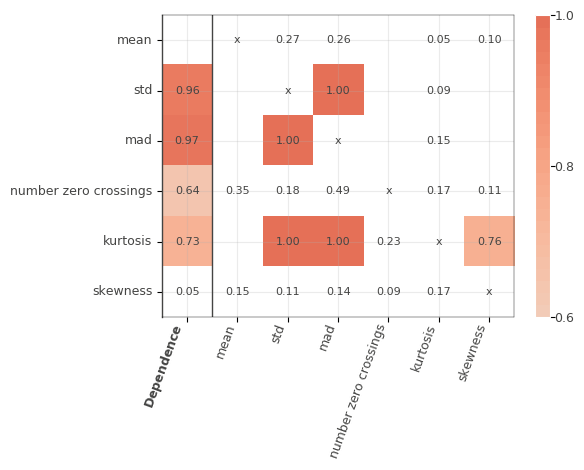

In [41]:
plt.rcParams.update(plt.rcParamsDefault)
rfpimp.plot_dependence_heatmap(fdm_reduced_further, value_fontsize=8, label_fontsize=9)
plt.rcParams.update(utils.get_plt_settings())

# Correlation Heatmap

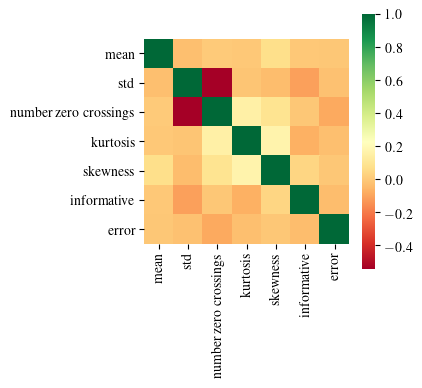

In [20]:
width, _ = utils.get_plt_normal_size()

plt.figure(figsize=(width*0.8, width*0.8))

cols = ['mean', 'std', 'number zero crossings', 'kurtosis', 'skewness', 'informative', 'error']
sns.heatmap(df.loc[x_train.index, cols].corr(), square=True, cmap ="RdYlGn")

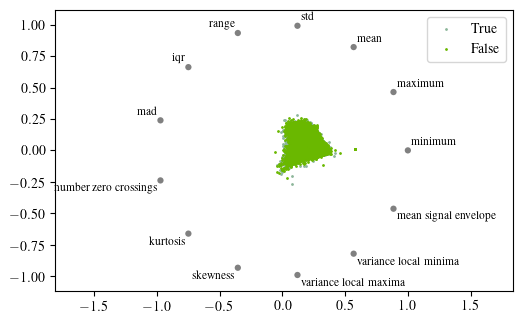

In [30]:
from pandas.plotting import radviz

fig, ax = plt.subplots(figsize=utils.get_plt_big_size())
radviz_df = x_train.copy()
radviz_df['target'] = y_train
radviz(radviz_df, "target", ax=ax, s=1)

# Random Forest

In [1]:
from sklearn.ensemble import RandomForestClassifier
from estimators import OwnEstimatorClassification

rf_reduced = RandomForestClassifier(n_random_state=1, max_depth=4, n_jobs=-2)

features_reduced = ['mean', 'std', 'number_zero_crossings', 'kurtosis', 'skewness']

clf_reduced = OwnEstimatorClassification(rf_reduced, "RF_reduced_statistical_2110", feature_selection=features_reduced)

Modell is trained, this may need some time


In [ ]:
rf = RandomForestClassifier(random_state=1)
from sklearn.model_selection import LeaveOneGroupOut, RandomizedSearchCV
cv = LeaveOneGroupOut()
parameters = {
        'n_estimators': [25, 50, 75, 100, 150],
        'criterion': ("gini", "entropy"),
        'max_depth': [3, 5, 7, 10],
        'class_weight': ("balanced", None)
}
grid_search = RandomizedSearchCV(estimator=rf, param_distributions=parameters, cv=cv, n_jobs=-2, verbose=2, n_iter=15)
grid_search.fit(x_train, y_train, groups=groups_train)

Fitting 9 folds for each of 15 candidates, totalling 135 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.


In [ ]:
print(grid_search.best_params_)
rf_new = grid_search.best_estimator_

In [2]:
clf_reduced.features.columns

Index(['mean', 'std', 'number_zero_crossings', 'kurtosis', 'skewness'], dtype='object')


 Testset insgesamt
Fehler < 5    : 32.61 %
Fehler < 10   : 43.21 %
Fehler < 15   : 51.64 %
Fehler < 20   : 59.40 %
Fehler = 667  : 0.09578 %
                 precision    recall  f1-score   support

non-informative       0.69      0.36      0.47    144049
    informative       0.48      0.79      0.60    109654

       accuracy                           0.55    253703
      macro avg       0.59      0.58      0.54    253703
   weighted avg       0.60      0.55      0.53    253703

MAE auf als informativ klassifizierten Segmenten: 19.27
MAE auf als informativ annotierten Segmenten:  3.28
MAE insgesamt:  21.85
MSE auf als informativ klassifizierten Segmenten: 888.41
MSE auf als informativ annotierten Segmenten:  17.83
MSE insgesamt:  1406.50


Coverage klassifiziert      : 70.76 %
Coverage annotiert          : 43.22 %

 Coverage bestimmter Fehler des genutzten Signals auf Gesamtsignal
Fehler < 5 gesamt           : 32.61 %
Fehler < 5 klassifiziert    : 26.86 %
Fehler < 10 gesamt         

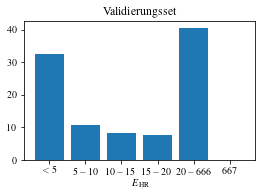

<Figure size 297.644x183.958 with 0 Axes>

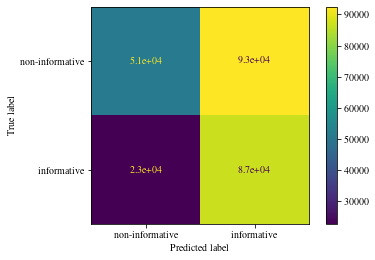

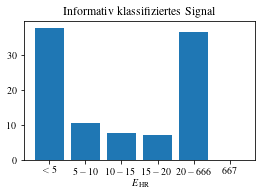

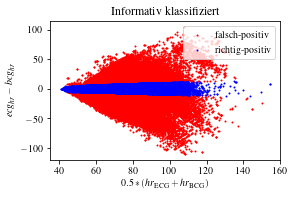

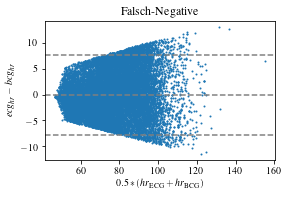

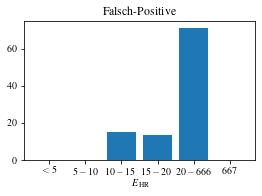

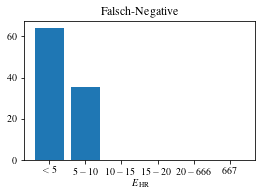

In [3]:
# plt.rcParams['axes.grid'] = False
clf_reduced.print_model_test_report()

0.5093748240693441
              precision    recall  f1-score   support

       False       0.62      0.59      0.60     14395
        True       0.49      0.52      0.50     10973

    accuracy                           0.56     25368
   macro avg       0.55      0.55      0.55     25368
weighted avg       0.56      0.56      0.56     25368



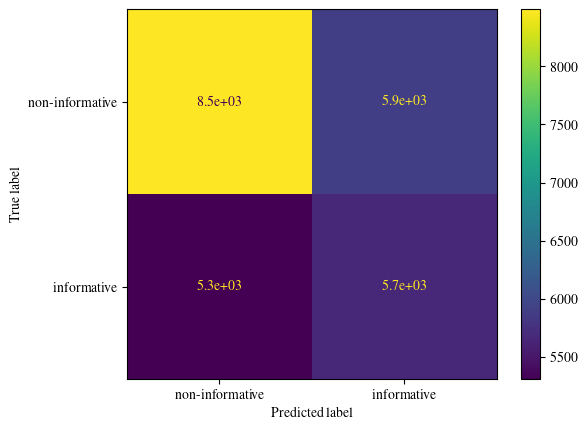

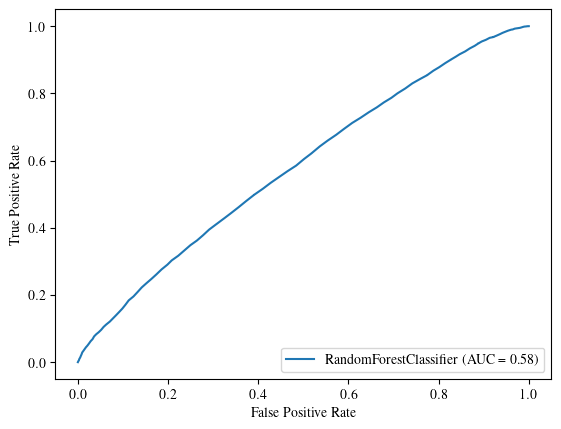

In [47]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, plot_roc_curve
from sklearn.model_selection import cross_val_score, LeaveOneGroupOut

cv = LeaveOneGroupOut()
print(cross_val_score(rf_reduced, x_train_reduced, y=y_train, cv=cv, groups=groups_train).mean())

class_names = ['non-informative', 'informative']
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=class_names).plot()

print(classification_report(y_test, y_pred))
plot_roc_curve(rf_reduced, x_test_reduced, y_test)

 1) std                            0.508167
 2) kurtosis                       0.172518
 3) skewness                       0.165340
 4) number zero crossings          0.127671
 5) mean                           0.026304


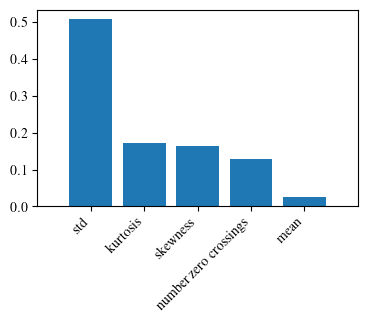

In [16]:
importances = rf_reduced.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(len(x_train_reduced.columns)):
    print("%2d) %-*s %f" % (f + 1, 30, x_train_reduced.columns[indices[f]], importances[indices[f]]))
plt.figure(figsize=utils.get_plt_normal_size())
plt.bar(range(len(x_train_reduced.columns)), importances[indices], align='center')
plt.xticks(range(len(x_train_reduced.columns)), [name.replace("_", " ") for name in x_train_reduced.columns[indices]], rotation=45, ha="right")
plt.xlim([-1, len(x_train_reduced.columns)])
if save:
    plt.savefig(os.path.join(utils.get_thesis_pic_path(),'rf-reduced-statistical.pdf'), bbox_inches='tight', transparent=True, dpi=300)

# Paarweise geplottet

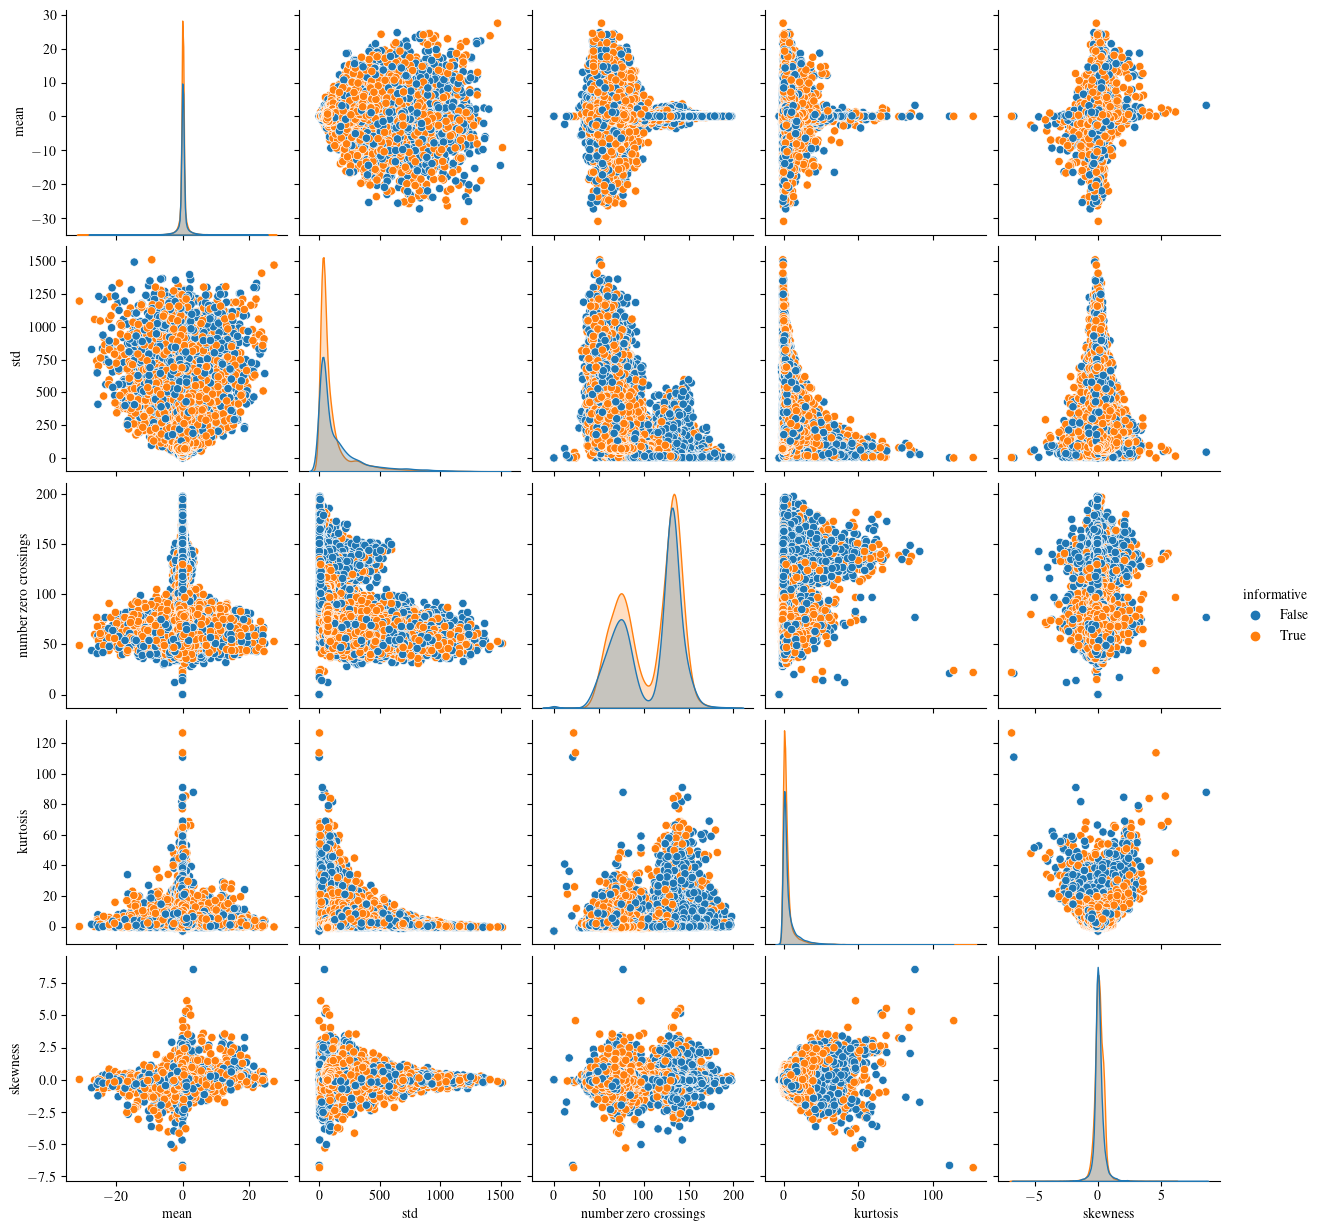

In [18]:
cols = ['mean', 'std', 'number zero crossings', 'kurtosis', 'skewness', 'informative']
sns.pairplot(df.loc[x_train.index, cols], kind='scatter', hue='informative')

# Feature Reduction

In [21]:
from sklearn.decomposition import KernelPCA, PCA
from sklearn.preprocessing import StandardScaler

In [22]:
std_scaler = StandardScaler()

x_std = std_scaler.fit_transform(x_test)

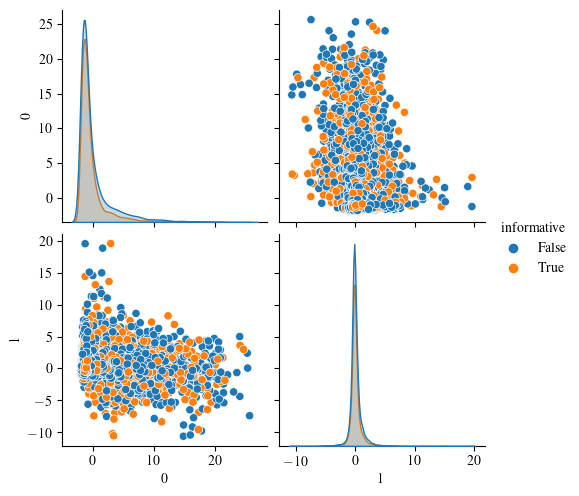

In [23]:
pca = PCA(n_components=2)
x_transform = pca.fit_transform(x_std)
df_linear = pd.DataFrame(x_transform)
df_linear['informative'] = y_test.values

sns.pairplot(df_linear, kind='scatter', hue='informative')

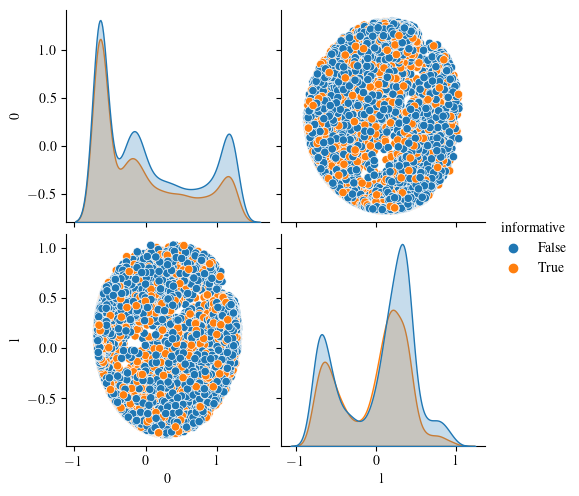

In [24]:
pca_cosine = KernelPCA(n_components=2, kernel='cosine')
x_transform = pca_cosine.fit_transform(x_std)
df_cosine = pd.DataFrame(x_transform)
df_cosine['informative'] = y_test.values

sns.pairplot(df_cosine, kind='scatter', hue='informative')

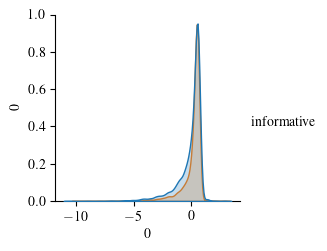

In [25]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis(n_components=1)
clf.fit(x_std, y_test)
x_lda = clf.transform(x_std)
df_lda = pd.DataFrame(x_lda)
df_lda['informative'] = y_test.values

sns.pairplot(df_lda, kind='scatter', hue='informative')

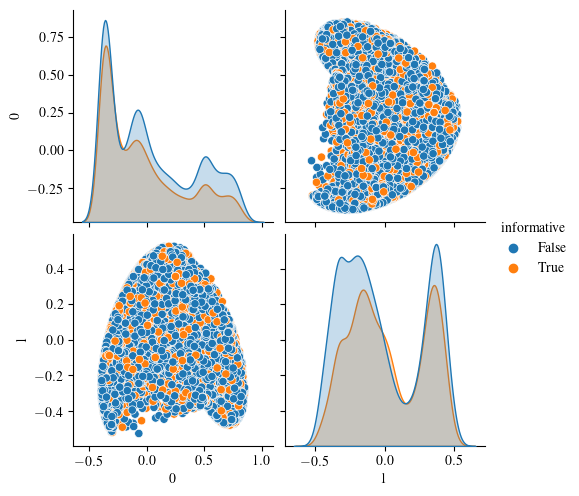

In [26]:
pca_rbf = KernelPCA(n_components=2, kernel='rbf', degree=3)
x_transform = pca_rbf.fit_transform(x_std)

df_rbf = pd.DataFrame(x_transform)
df_rbf['informative'] = y_test.values

sns.pairplot(df_rbf, kind='scatter', hue='informative')